In [12]:
# note Grakel does not seem to support Python >=3.10, Python 3.9 works fine
# you are free to remove imports that are not useful for you

#import sys
#!{sys.executable} -m pip install sympy
#!{sys.executable} -m pip install matplotlib
from grakel.datasets import fetch_dataset
from grakel.kernels import WeisfeilerLehman, VertexHistogram
from sklearn.model_selection import train_test_split,cross_val_score
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from sklearn.decomposition import KernelPCA # to check your own implementation
from sklearn.manifold import TSNE
from matplotlib import pyplot as plot
import numpy as np
import scipy
import matplotlib.pyplot as plt
import math

In [13]:
# Some datasets, more datasets here https://ls11-www.cs.tu-dortmund.de/staff/morris/graphkerneldatasets
"""
    The MUTAG dataset consists of 188 chemical compounds divided into two 
    classes according to their mutagenic effect on a bacterium. 

    The chemical data was obtained form http://cdb.ics.uci.edu and converted 
    to graphs, where vertices represent atoms and edges represent chemical 
    bonds. Explicit hydrogen atoms have been removed and vertices are labeled
    by atom type and edges by bond type (single, double, triple or aromatic).
    Chemical data was processed using the Chemistry Development Kit (v1.4).
"""

"""
    ENZYMES is a dataset of protein tertiary structures obtained from (Borgwardt et al., 2005) 
    consisting of 600 enzymes from the BRENDA enzyme database (Schomburg et al., 2004). 
    In this case the task is to correctly assign each enzyme to one of the 6 EC top-level 
    classes. 
"""

"""
    NCI1 and NCI109 represent two balanced subsets of datasets of chemical compounds screened 
    for activity against non-small cell lung cancer and ovarian cancer cell lines respectively
    (Wale and Karypis (2006) and http://pubchem.ncbi.nlm.nih.gov).
"""

dataset = fetch_dataset("MUTAG",verbose=False) # just replace by the name of the datasets you want "ENZYMES", "NCI1"
G = dataset.data
y = dataset.target


wl_kernel = WeisfeilerLehman(n_iter=10, base_graph_kernel=VertexHistogram)
K_train = wl_kernel.fit_transform(G)

print("Kernel matrix: ")
print(K_train)

print("Trace of the kernel matrix "+ str(np.linalg.matrix_rank(K_train)))


Kernel matrix: 
[[507 210 206 ... 189 473 289]
 [210 263 145 ... 126 260 181]
 [206 145 263 ... 129 256 186]
 ...
 [189 126 129 ... 228 231 179]
 [473 260 256 ... 231 859 361]
 [289 181 186 ... 179 361 396]]
Trace of the kernel matrix 175


*Center Kernel*

In [25]:
def center_K(K):
    len_K = len(K)
    N1 = np.full((len_K, len_K), 1/len_K)

    return (K -(N1 @ K) - (K @ N1) + (N1 @ K @ N1))
    
#center_K(K_train)

*KPCA*

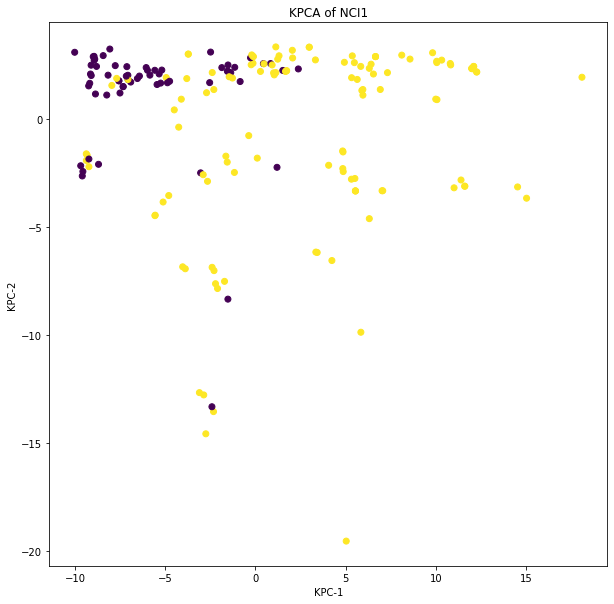

c:\Users\Pierre\AppData\Local\Programs\Python\Python39\lib\site-packages\matplotlib\cbook\__init__.py:1333: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


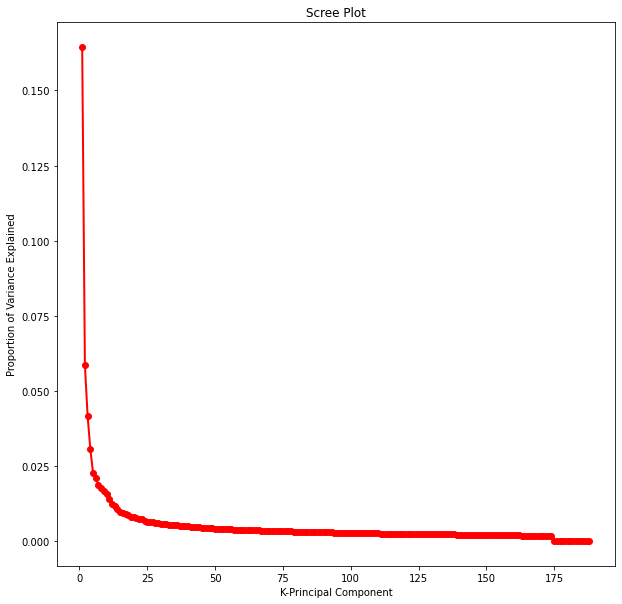

In [27]:
def display_3D(data):
    """display in a 3 dimensionnal space list of observations based on 3 coords
    """
    data = np.transpose(data)
    fig = plt.figure(figsize=(10,10))
    plot_3D = fig.add_subplot(111, projection='3d')
    plot_3D.scatter(data[0],data[1],data[2], c=y)
    plt.show()
    return

def display_2D(data):
    """display in a 2 dimensionnal space list of observations based on 2 coords
    """
    data = np.transpose(data)
    fig = plt.figure(figsize=(10,10))
    plot_2D = fig.add_subplot(111)
    plot_2D.scatter(data[0],data[1], c=y)
    plt.xlabel('KPC-1')
    plt.ylabel('KPC-2')
    plt.title('KPCA of NCI1')
    plt.show()
    return

def get_variation(K):
    """Scree plot of K
    """
    len_k = len(K)
    vals, _ = np.linalg.eig(K)

    # sort these based on the eigenvalues
    vals = np.flip(vals[np.argsort(vals)],0)
    total_variation = np.sum(vals)

    # Compute the percentage of variance for each eigenvectors
    purcentage_vari = vals / total_variation

    fig = plt.figure(figsize=(10,10))
    plt.plot(range(1, len(vals)+1), purcentage_vari, 'ro-', linewidth=2)
    plt.title('Scree Plot')
    plt.xlabel('K-Principal Component')
    plt.ylabel('Proportion of Variance Explained')
    plt.show()

    return 
    

def kernel_PCA(K, dim):
    """Compute the KPCA of the kernel K to the dimension dim
    ----------------------
    K: Matrix kernel used to compute the KPCA
    dim: dimension of the new space
    ----------------------
    return: the new coords of the sample based on the new dim
    """
    vals, vecs = np.linalg.eig(K)
    #skipy give same but swapped 
    vecs = np.transpose(vecs)

    # sort these based on the eigenvalues
    vecs = np.flip(vecs[np.argsort(vals)],0)[:dim]
    vals = np.flip(vals[np.argsort(vals)],0)[:dim]

    # normalize the eigenvectors based on the square root of the corresponding eigenvalue
    for i in range(dim):
        vecs[i] = (vecs[i] / np.sqrt(vals[i]))

    feature_space = []

    # Project the Kernel on these new components
    for i in range(len(K)):
        new_coord = []
        for coord in range(dim):
            new_coord.append(K[:,i]@vecs[coord])
            
        feature_space.append(new_coord)

    return np.real(feature_space)


display_2D(kernel_PCA(center_K(K_train), 2))

get_variation(center_K(K_train))
    

*Compute the pairwise distance of the Kernel*

In [28]:
def pairwise_dist(K):
    """Computer the pairwise distance for a kernel K
    """
    dist=np.empty((len(K),len(K)))

    for i in range(len(K)):
        for j in range(len(K)):
            
            dist[i][j] = np.sqrt((K[i][i] + K[j][j] -2*K[i][j]))

    return np.matrix(dist)


#pairwise_dist(K_train)

*TSNE*

c:\Users\Pierre\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\manifold\_t_sne.py:691: FutureWarning: 'square_distances' has been introduced in 0.24 to help phase out legacy squaring behavior. The 'legacy' setting will be removed in 1.1 (renaming of 0.26), and the default setting will be changed to True. In 1.3, 'square_distances' will be removed altogether, and distances will be squared by default. Set 'square_distances'=True to silence this warning.
  warnings.warn(


[t-SNE] Computing 151 nearest neighbors...
[t-SNE] Indexed 188 samples in 0.000s...
[t-SNE] Computed neighbors for 188 samples in 0.005s...
[t-SNE] Computed conditional probabilities for sample 188 / 188
[t-SNE] Mean sigma: 1.051460
[t-SNE] KL divergence after 250 iterations with early exaggeration: 58.383389
[t-SNE] KL divergence after 1000 iterations: 0.253922


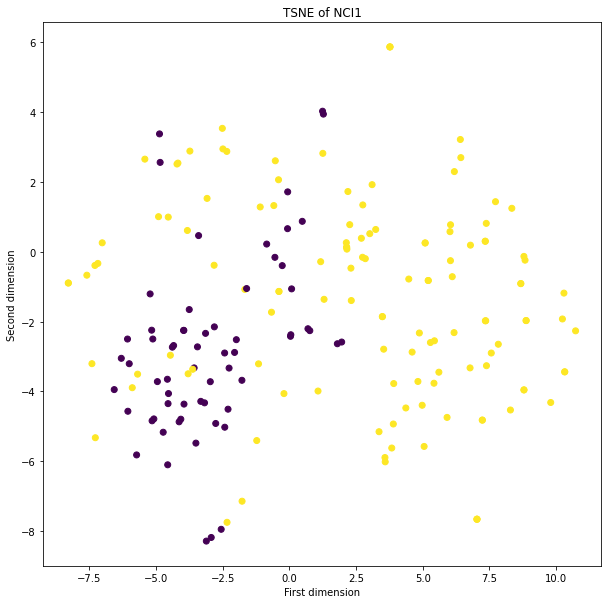

In [29]:
def display_TSNE(data):
    """display in a 2 dimensionnal space list of observations based on 2 coords
    """
    data = np.transpose(data)
    fig = plt.figure(figsize=(10,10))
    plot_2D = fig.add_subplot(111)
    plot_2D.scatter(data[0],data[1], c=y)
    plt.xlabel('First dimension')
    plt.ylabel('Second dimension')
    plt.title('TSNE of NCI1')
    plt.show()
    return

def tsne(pp):
    """Compute the TSNE of the Kernel and display it
    ----------------------------
    pp: perplexity used (number of neighbours considered)
    """
    model = TSNE(n_components=2, perplexity=pp, metric='precomputed', verbose=1)
    coords = model.fit_transform(pairwise_dist(K_train))
    display_TSNE(coords)

tsne(50)

*Constant model*

In [18]:
from collections import Counter

def constant_model_accuracy():
    """Get the frequency of the class wich is the most represented"""
    test_list = Counter(y)
    res = test_list.most_common(1)
    return np.around(res[0][1] / len(y), 3) * 100

constant_model_accuracy()

66.5

*Plot accuracy of constant model*

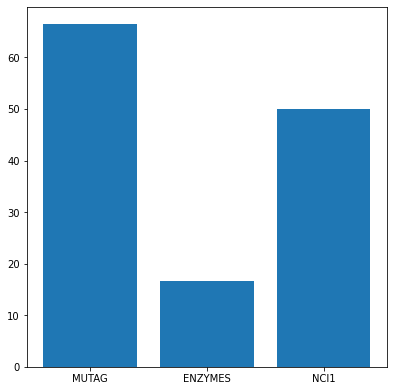

In [19]:
datasets = ['MUTAG', 'ENZYMES', 'NCI1']
accuracy_constant = [66.5, 16.7, 50.0]

fig = plt.figure(figsize=(5,5))

ax = fig.add_axes([0,0,1,1])
ax.bar(datasets,accuracy_constant)
plt.show()


*Compute a SVC*

In [30]:
def SVM(seta, target, risk, H):
    """Train a SVC model
    -------------------------
    seta: initial dataset
    target: target of the observations
    risk: Hyperparameter of C
    H: number of iteration for the WeisfeilerLehma kernel
    -------------------------
    return the accuracy of the model based on the testing set
    """

    # Split the initial dataset in a training and testing set
    G_train, G_test, y_train, y_test =  train_test_split(seta, target, test_size=0.2, random_state=42)

    # Create the model with the hyperparameter 
    clf = SVC(C=risk,kernel='precomputed')

    # Create the WeisfeilerLehman kernel based on the number of iteration
    wl_kernel_2 = WeisfeilerLehman(n_iter= H, base_graph_kernel=VertexHistogram)
    # Transform the training set in a Kernel
    Trained = wl_kernel_2.fit_transform(G_train)

    # Transform the testing set in a Kernel
    G_test_transformed = wl_kernel_2.transform(G_test)

    #Train our SVC with the training Kernel
    clf.fit(Trained, y_train)
    
    return clf.score(G_test_transformed, y_test)

print(SVM(G,y,100,3))




0.8947368421052632


*Selection of hyperparameters*

In [32]:
C= [10**-5 , 10**-4 , 10**-3 , 10**-2 , 10**-1 , 10 , 10**1 , 10**2 , 10**3 , 10**4]
H= [1,2,3,4,5,6,7,8,9,10]

def Select_hyperparameters2(seta , target , C , H):
    """Compute a grid research for the hyperparameters C and H based on 10 fold cross validation
    ---------------------------
    seta: initial dataset
    target: target of the observations
    C: List of hyperparameter of C
    H: List of number of iteration for the WeisfeilerLehma kernel
    """

    # Define our validation matrix score
    matrix = np.zeros((len(C),len(H)))

    # Split the dataset
    G_train, _, y_train, _ =  train_test_split(seta, target, test_size=0.2, random_state=42)
    
    for i in range (len(C)):
        # Create SVC model based on C
        clf = SVC(C=C[i],kernel='precomputed')
        
        for j in range (len(H)):
            
            
            #Train the kernel
            wl_kernel_2 = WeisfeilerLehman(n_iter= H[j], base_graph_kernel=VertexHistogram)
            Trained = wl_kernel_2.fit_transform(G_train)

            #Cross ealuate the model with the hyperparameters C and using the training set 
            scores = cross_val_score(clf, Trained, y_train, cv=10)
            matrix[i][j] = np.mean(scores)
            
            
    return matrix
    
matrix_result = Select_hyperparameters2(G,y,C,H)
# Display the combinations that maximize the validation score
index = np.where(matrix_result == matrix_result.max())
for i in range (len(index[0])):
    print("combination of C = %f and H = %d give value %f which is maximum" %(C[index[0][i]], H[index[1][i]], matrix_result.max()) )

combination of C = 0.010000 and H = 1 give value 0.853333 which is maximum
combination of C = 0.010000 and H = 5 give value 0.853333 which is maximum
combination of C = 0.100000 and H = 1 give value 0.853333 which is maximum


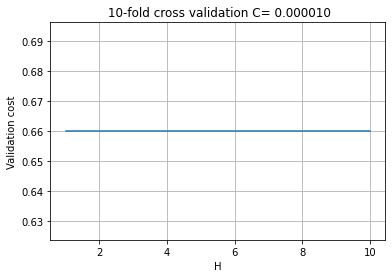

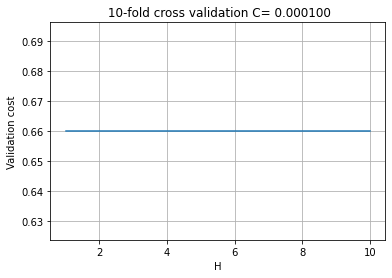

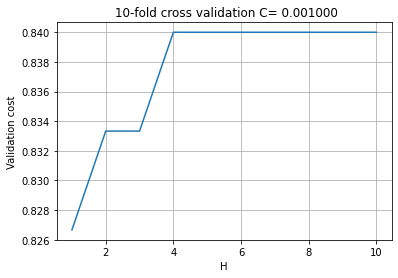

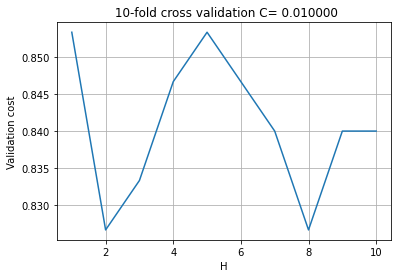

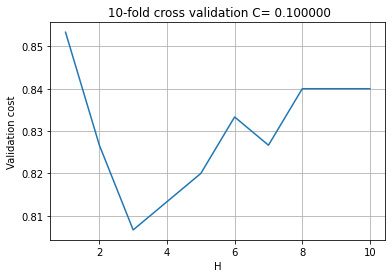

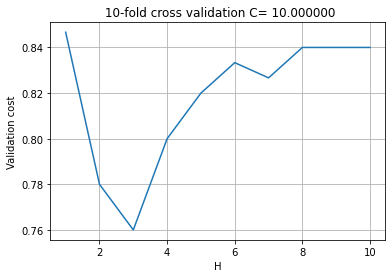

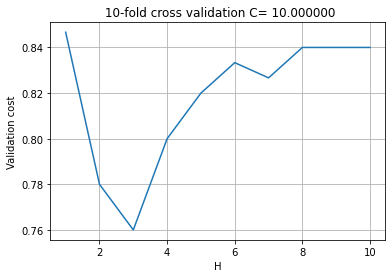

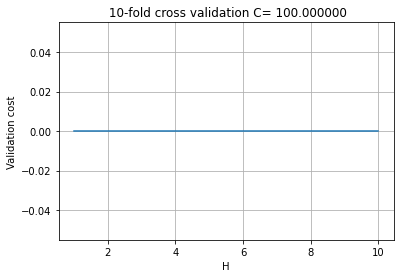

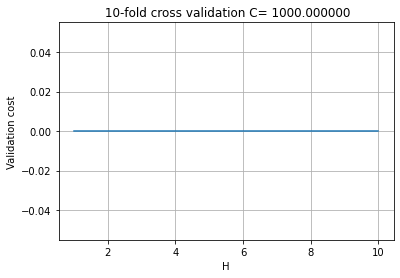

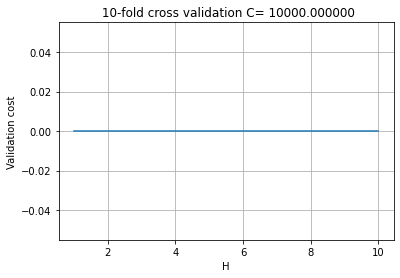

In [23]:
# Plot the evolution of the accuracy based on C and the different H for the C selected
for i in range(len(C)):
    plt.plot(H, matrix_result[i])
    plt.xlabel("H")
    plt.ylabel("Validation cost")
    plt.title(' 10-fold cross validation C= %f' %(C[i]))
    plt.grid()
    plt.show()